<a href="https://colab.research.google.com/github/zoujiulong/Multimodal/blob/main/Stable_Diffusioin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q omegaconf torchvision tqdm matplotlib open_clip_torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 74.5 MB/s eta 0:00:00


In [2]:
import math
import torch
import torch.nn as nn

# class TimeEmedding(nn.Module):
#     def __init__(self,in_channel):
#         super().__init__()
#         self.in_channel=in_channel
#         self.proj1=nn.Linear(in_channel//4,in_channel)
#         self.act1=nn.ELU()
#         self.proj2=nn.Linear(in_channel,in_channel)
#     def forward(self,t):
#         print('t',t.shape)
#         # t_emb=torch.empty((*t.shape[:-1],self.in_channel//4))
#         print('t_emb',t_emb.shape)
#         emb=math.log(10000)/(self.in_channel//8)
#         emb=t[:,None]*torch.exp(torch.arange(self.in_channel//8)*-emb)
#         print('emb',emb.shape)
#         t_emb[:,:,:,::2]=emb.sin()
#         t_emb[:,:,:,1::2]=emb.cos()
#         t_emb=self.proj1(t_emb)
#         t_emb=self.act1(t_emb)
#         t_emb=self.proj2(t_emb)
#         return t_emb

class Swish(nn.Module):
    """
    ### Swish activation function

    $$x \cdot \sigma(x)$$
    """

    def forward(self, x):
        return x * torch.sigmoid(x)

class TimeEmbedding(nn.Module):
    """
    ### Embeddings for $t$
    """

    def __init__(self, n_channels: int):
        """
        * `n_channels` is the number of dimensions in the embedding
        """
        super().__init__()
        self.n_channels = n_channels
        # First linear layer
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Activation
        self.act = Swish()
        # Second linear layer
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        # Create sinusoidal position embeddings
        # [same as those from the transformer](../../transformers/positional_encoding.html)
        #
        # \begin{align}
        # PE^{(1)}_{t,i} &= sin\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg) \\
        # PE^{(2)}_{t,i} &= cos\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg)
        # \end{align}
        #
        # where $d$ is `half_dim`
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        # Transform with the MLP
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)
        return emb

class SpatialAttention(nn.Module):
  def __init__(self,in_dim,heads,head_dim,types='crossattn',text_dim=1024):
    super().__init__()
    # self.norm1=nn.LayerNorm(in_dim)
    inner_dim=head_dim*heads
    self.types=types
    self.heads=heads
    self.head_dim=head_dim
    self.q=nn.Linear(in_dim,inner_dim)
    if types!='crossattn':
      text_dim=in_dim
    self.k=nn.Linear(text_dim,inner_dim)
    self.v=nn.Linear(text_dim,inner_dim)
    self.act=nn.Softmax(dim=-1)
    self.drop1=nn.Dropout()
    self.linear=nn.Linear(inner_dim,inner_dim)
    self.drop2=nn.Dropout()
    self.norm2=nn.LayerNorm(in_dim)
    self.ffn=nn.Sequential(
        nn.Linear(in_dim,4*in_dim),
        nn.GELU(),
        nn.Linear(4*in_dim,in_dim)
    )

    self.mlp1=nn.Sequential(
        nn.Linear(2 * inner_dim, 3 * inner_dim),
        nn.ReLU(),
        nn.Linear(3 * inner_dim, 3 * inner_dim),
    )

    self.mlp2=nn.Sequential(
        nn.Linear(2 * inner_dim, 3 * inner_dim),
        nn.ReLU(),
        nn.Linear(3 * inner_dim, 3 * inner_dim),
    )
    self.to_out = nn.Sequential(
        nn.Linear(inner_dim, in_dim),
        nn.Dropout(0.1)
    )

  def forward(self,x,c=None):
    b,ch,h,w=x.shape
    alpha=None
    if self.types=='ada':
      gamma,beta,alpha=self.mlp1(c.view(b,-1)).view(b,3,-1).chunk(3,dim=1)
      x=gamma*self.norm1(x)+beta
    else:
      # x=self.norm1(x)
      x=x
    x=x.permute(0,2,3,1).view(b,-1,ch)
    q=self.q(x).view(b,-1,self.heads,self.head_dim).permute(0,2,1,3)
    if self.types=='crossattn':
      k=self.k(c).view(b,-1,self.heads,self.head_dim).permute(0,2,1,3)
      v=self.v(c).view(b,-1,self.heads,self.head_dim).permute(0,2,1,3)
    else:
      k=self.k(x).view(b,-1,self.heads,self.head_dim).permute(0,2,1,3)
      v=self.v(x).view(b,-1,self.heads,self.head_dim).permute(0,2,1,3)
    inter=self.drop1(self.act(q@k.transpose(-1,-2)/math.sqrt(q.shape[-1])))
    o=(inter@v).permute(0,2,1,3).flatten(2)
    o=self.drop2(self.linear(o))
    if self.types=='ada':
      o=self.norm2(alpha*o+x)
      gamma,beta,alpha=self.mlp2(c.view(b,-1)).view(b,3,-1).chunk(3,dim=1)
      o=gamma*o+beta
      o=o+alpha*self.ffn(o)
    else:
      o=self.to_out(o)
      o=self.norm2(o+x)
      o=o+self.ffn(o)
    o=o.permute(0,2,1).view(b,-1,h,w)
    return o

class ResidualBlock(nn.Module):
    def __init__(self,in_channel,out_channel,time_channel,n_groups=4,p=0.1):
        super().__init__()
        self.in_ch=in_channel
        # self.ins1=nn.InstanceNorm2d(in_channel)
        # print(in_channel)
        self.ins1=nn.GroupNorm(n_groups, in_channel)
        # self.act1=nn.ELU()
        self.act1=Swish()
        self.conv1=nn.Conv2d(in_channel,out_channel,kernel_size=(3,3),padding=1)
        # self.ins2=nn.InstanceNorm2d(in_channel)
        self.ins2=nn.GroupNorm(n_groups, out_channel)
        self.act2=Swish()
        self.conv2=nn.Conv2d(out_channel,out_channel,kernel_size=(3,3),padding=1)
        if in_channel!=out_channel:
            self.residual=nn.Conv2d(in_channel,out_channel,kernel_size=(1,1))
        else:
            self.residual=nn.Identity()
        self.time_emb = nn.Linear(time_channel, out_channel)
        self.time_act = Swish()
        self.dropout = nn.Dropout(p)
    def forward(self,img,t):
        out=self.conv1(self.act1(self.ins1(img)))
        print('out',out.shape)
        # out+=self.time_emb(self.time_act(t)).permute(0,3,1,2)
        if t is not None:
          out+=self.time_emb(self.time_act(t))[:, :, None, None]
        out=self.conv2(self.dropout(self.act2(self.ins2(out))))
        out+=self.residual(img)
        return out

class DownBlock(nn.Module):
    def __init__(self,in_channel,out_channel,time_channel,head_num,has_attention=False,types='crossattn'):
        super().__init__()
        self.residual=ResidualBlock(in_channel,out_channel,time_channel)
        if has_attention:
            self.attention=SpatialAttention(out_channel,12,64,types=types)
        else:
            self.attention=nn.Identity()

    def forward(self,img,t,c=None):
        out=self.residual(img,t)
        if isinstance(self.attention,SpatialAttention):
          out=self.attention(out,c)
        else:
          out=self.attention(out)
        return out

class MiddleBlock(nn.Module):
    def __init__(self,in_channel,out_channel,time_channel,head_num,types=''):
        super().__init__()
        self.residual1=ResidualBlock(in_channel,out_channel,time_channel)
        self.attention=SpatialAttention(out_channel,12,64,types=types)
        self.residual2=ResidualBlock(out_channel,out_channel,time_channel)
    def forward(self,img,t):
        out=self.residual1(img,t)
        out=self.attention(out)
        print('attention')
        out=self.residual2(out,t)
        return out

class UpBlock(nn.Module):
    def __init__(self,in_channel,out_channel,time_channel,head_num,has_attention=False,types='crossattn'):
        super().__init__()
        self.residual=ResidualBlock(in_channel+out_channel,out_channel,time_channel)
        if has_attention:
            self.attention=SpatialAttention(out_channel,12,64,types=types)
        else:
            self.attention=nn.Identity()
    def forward(self,img,t,c=None):
        out=self.residual(img,t)
        if isinstance(self.attention,SpatialAttention):
          out=self.attention(out,c)
        else:
          out=self.attention(out)
        return out

class DownSampleBlock(nn.Module):
    def __init__(self,in_channel):
        super().__init__()
        self.conv=nn.Conv2d(in_channel,in_channel,kernel_size=(3,3),stride=(2,2),padding=(1,1))
    def forward(self,img,t,c=None):
        _=t
        _=c
        return self.conv(img)

class UpSampleBlock(nn.Module):
    def __init__(self,in_channel):
        super().__init__()
        self.conv=nn.ConvTranspose2d(in_channel,in_channel,kernel_size=(4,4),stride=(2,2),padding=(1,1))
    def forward(self,img,t):
        _=t
        return self.conv(img)

class Unet(nn.Module):
    def __init__(self,layers,img_ch=1,in_channel=64,blocks=2,resolution=64,att_resolution=[32,16],head_num=8):
        super().__init__()
        down=[]
        coe=(1,2,2,4)
        self.conv1=nn.Conv2d(img_ch,in_channel,kernel_size=(3,3),padding=(1,1))
        self.textembed=TextEmbeddding()
        self.time=TimeEmbedding(in_channel*4)
        n_channel=in_channel
        cur_res=resolution
        for i in range(layers):
            out_ch=coe[i]*in_channel
            # print(out_ch)
            # print(in_channel)
            for _ in range(blocks):
              if cur_res in att_resolution:
                down.append(DownBlock(in_channel,out_ch,n_channel*4,head_num,True))
              else:
                down.append(DownBlock(in_channel,out_ch,n_channel*4,head_num))
              in_channel=out_ch
            # print(in_channel)
            # print(out_ch)
            if i<layers-1:
                down.append(DownSampleBlock(out_ch))
                cur_res//=2
        self.down=nn.ModuleList(down)
        self.middle=MiddleBlock(out_ch,out_ch,n_channel*4,head_num)
        up=[]
        in_channel=out_ch
        for i in range(layers):
            out_ch=in_channel
            for _ in range(blocks):
              if cur_res in att_resolution:
                up.append(UpBlock(in_channel,out_ch,n_channel*4,head_num,True))
              else:
                up.append(UpBlock(in_channel,out_ch,n_channel*4,head_num))
            out_ch=in_channel//coe[layers-1-i]
            if cur_res in att_resolution:
              up.append(UpBlock(in_channel,out_ch,n_channel*4,head_num,True))
            else:
              up.append(UpBlock(in_channel,out_ch,n_channel*4,head_num))
            in_channel=out_ch
            if i<layers-1:
              cur_res*=2
              up.append(UpSampleBlock(in_channel))
        self.up=nn.ModuleList(up)
        # self.ins=nn.InstanceNorm2d(in_channel)
        self.ins=nn.GroupNorm(8, n_channel)

        # self.act=nn.ELU()
        self.act=Swish()
        self.conv2=nn.Conv2d(in_channel,img_ch,kernel_size=(3,3),padding=(1,1))

    def forward(self,x,c,t):
        out=self.conv1(x)
        t=self.time(t)
        record=[out]
        for down in self.down:
            out=down(out,t,c)
            print('out')
            record.append(out)
        out=self.middle(out,t)
        for up in self.up:
            if isinstance(up,UpSampleBlock):
                out=up(out,t)
            else:
                out=torch.cat((out,record.pop()),dim=1)
                out=up(out,t,c)
        out=self.conv2(self.act(self.ins(out)))
        return out

In [3]:
class TextEmbeddding(nn.Module):
  def __init__(self,embed_dim=1024,model_path='/content/drive/MyDrive/open_clip_pytorch_model.bin',mode='ViT-H-14'):
    super().__init__()
    model, _, _ = open_clip.create_model_and_transforms(mode, pretrained=None)
    state_dict = torch.load(model_path, map_location='cpu')
    # 加载权重
    model.load_state_dict(state_dict)
    self.model=model
    self.tokenizer=open_clip.get_tokenizer(mode)
  def forward(self,text):
    tokens=self.tokenizer(text)
    text_feature=self.model.encode_text(tokens)
    return text_feature

In [4]:
class Encoder(nn.Module):
    def __init__(self,z_ch,embed_dim,ch_mult=(1,2,2,4),img_ch=1,resolution=256,att_resolution=[32],in_channel=64,blocks=2,head_num=8):
        super().__init__()
        down=[]
        layers=len(ch_mult)
        self.conv1=nn.Conv2d(img_ch,in_channel,kernel_size=(3,3),padding=(1,1))
        self.time=TimeEmbedding(in_channel*4)
        n_channel=in_channel
        cur_res=resolution
        for i in range(layers):
            out_ch=ch_mult[i]*in_channel
            for _ in range(blocks):
              if cur_res in att_resolution:
                down.append(DownBlock(in_channel,out_ch,n_channel*4,head_num,True,types=''))
              else:
                down.append(DownBlock(in_channel,out_ch,n_channel*4,head_num))
              in_channel=out_ch
            if i<layers-1:
              cur_res//=2
              down.append(DownSampleBlock(out_ch))
        self.down=nn.ModuleList(down)
        self.middle=MiddleBlock(out_ch,out_ch,n_channel*4,head_num)
        self.ins=nn.InstanceNorm2d(in_channel)
        self.act=nn.ELU()
        self.conv2=nn.Conv2d(in_channel,z_ch,kernel_size=(3,3),padding=(1,1))
        self.dis=nn.Conv2d(2*z_ch,2*embed_dim,1)
    def sample(self,z):
      mean,log_var=self.dis(z).chunk(2,dim=1)
      std=torch.exp(0.5*log_var)
      x=mean+torch.randn(mean.shape)*std
      return x
    def forward(self,x,t):
        out=self.conv1(x)
        if t is not None:
          t=self.time(t)
        record=[out]
        for down in self.down:
            out=down(out,t)
            print('out')
            record.append(out)
        out=self.middle(out,t)
        out=self.conv2(self.act(self.ins(out)))
        return out

In [5]:
class Decoder(nn.Module):
    def __init__(self,z_ch,ch_multi=(1,2,2,4),resolution=32,img_ch=1,att_resolution=[32],in_channel=64,blocks=2,head_num=8):
        super().__init__()
        layers=len(ch_multi)
        self.conv1=nn.Conv2d(z_ch,in_channel,kernel_size=(3,3),padding=(1,1))
        self.time=TimeEmbedding(in_channel*4)
        n_channel=in_channel
        self.middle=MiddleBlock(in_channel,in_channel,n_channel*4,head_num)
        up=[]
        cur_res=resolution
        for i in range(layers):
            out_ch=in_channel
            print('out_ch',out_ch)
            for _ in range(blocks):
              if cur_res in att_resolution:
                up.append(ResidualBlock(in_channel,out_ch,n_channel*4))
              else:
                up.append(ResidualBlock(in_channel,out_ch,n_channel*4))
            out_ch=in_channel//ch_multi[layers-1-i]
            if cur_res in att_resolution:
              up.append(ResidualBlock(in_channel,out_ch,n_channel*4))
            else:
              up.append(ResidualBlock(in_channel,out_ch,n_channel*4))
            in_channel=out_ch
            if i<layers-1:
              cur_res*=2
              up.append(UpSampleBlock(in_channel))
        self.up=nn.ModuleList(up)
        self.ins=nn.InstanceNorm2d(in_channel)
        self.act=nn.ELU()
        self.conv2=nn.Conv2d(in_channel,img_ch,kernel_size=(3,3),padding=(1,1))
    def forward(self,x,t):
        out=self.conv1(x)
        if t is not None:
          t=self.time(t)
        out=self.middle(out,t)
        for up in self.up:
          out=up(out,t)
        out=self.conv2(self.act(self.ins(out)))
        return out

In [10]:
class StableDiffusion(nn.Module):
  def __init__(self,beta_s,beta_e,time_steps,num_class,in_ch=1,types=''):
    super().__init__()
    self.types=types
    self.model=Unet(3,img_ch=in_ch)
    self.text_encoder=TextEmbeddding()
    self.num_class=num_class
    self.apply(self._init_weight)
    # param
    self.time_steps=time_steps
    beta=torch.linspace(beta_s,beta_e,time_steps).numpy()
    # yes
    alpha=1-beta
    #
    self.cum_prod_alpha=np.cumprod(alpha)
    self.cum_prod_alpha_prev=np.append(1,alpha[:-1])
    self.sqrt_cum_prod_alpha=torch.tensor(np.sqrt(self.cum_prod_alpha),dtype=torch.float32)
    self.sqrt_one_cum_prod_alpha=torch.tensor(np.sqrt(1-self.cum_prod_alpha),dtype=torch.float32)
    # self.optim=torch.optim.Adam(self.predict_model.parameters(),lr=2e-4)
    self.posterior_mean_coef1=torch.tensor(beta*np.sqrt(self.cum_prod_alpha_prev)/(1-self.cum_prod_alpha),dtype=torch.float32)
    self.posterior_mean_coef2=torch.tensor((1-self.cum_prod_alpha_prev)*np.sqrt(alpha)/(1-self.cum_prod_alpha),dtype=torch.float32)
    self.sqrt_recip_alphas_cumprod=torch.tensor(np.sqrt(1/self.cum_prod_alpha),dtype=torch.float32)
    self.sqrt_recipm1_alphas_cumprod=torch.tensor(np.sqrt(1/self.cum_prod_alpha-1),dtype=torch.float32)
    self.posterior_variance=torch.tensor(beta*(1-self.cum_prod_alpha_prev)/(1-self.cum_prod_alpha))
    self.posterior_log_variance_clipped=torch.tensor(np.log(np.maximum(self.posterior_variance,1e-20)),dtype=torch.float32)

  def p_sample(self,x,t,c):
    b=x.shape[0]
    noise=torch.randn_like(x)
    model_mean,_,model_log_var=self.p_mean_variance(x,t,c,noise)
    nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))
    return model_mean + nonzero_mask * (0.5 * model_log_var).exp() * noise

  def q_posterior(self, x_start, x_t, t):
      posterior_mean = (
              self.extract_into_tensor(self.posterior_mean_coef1, t, x_t.shape) * x_start +
              self.extract_into_tensor(self.posterior_mean_coef2, t, x_t.shape) * x_t
      )
      posterior_variance = self.extract_into_tensor(self.posterior_variance, t, x_t.shape)
      posterior_log_variance_clipped = self.extract_into_tensor(self.posterior_log_variance_clipped, t, x_t.shape)
      return posterior_mean, posterior_variance, posterior_log_variance_clipped

  def predict_start_from_noise(self, x_t, t, noise):
    print('t',t)
    print('x_t',x_t.shape)
    print('sqrt_recipm1_alphas_cumprod',self.sqrt_recipm1_alphas_cumprod.shape)
    print('noise',noise.shape)
    print('x_t shape',x_t.shape)
    out=(
            self.extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            self.extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
    )

    return out

  def p_mean_variance(self, x, t, c,clip_denoised: bool):
      model_out= self(x, t,c)
      x_recon = self.predict_start_from_noise(x, t=t, noise=model_out)
      model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start=x_recon, x_t=x, t=t)
      return model_mean, posterior_variance, posterior_log_variance

  def extract_into_tensor(self,a, t, x_shape):
    b, *_ = t.shape
    # print('extract',t,b)
    t=t.long().view(-1)
    out = a.gather(-1, t)
    # print('extract',out)
    # print(out.reshape(b, *((1,) * (len(x_shape) - 1))))
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

  def q_sample(self,x,t,noise):
    return self.extract_into_tensor(self.sqrt_cum_prod_alpha,t,x.shape)*x+self.extract_into_tensor(self.sqrt_one_cum_prod_alpha,t,x.shape)*noise

  def p_loss(self,x,t,c,noise):
    x_noise=self.diffusion(x,t,noise)
    pred=self(x_noise,t,c)
    loss=torch.nn.functional.mse_loss(pred,noise,reduction='none').mean()
    return loss

  def diffusion(self,x,t,noise):
    bs=x.shape[0]
    x_noise=self.q_sample(x,t,noise)
    return x_noise

  def _init_weight(self,m):
    if isinstance(m,nn.LayerNorm):
      nn.init.constant_(m.bias,0)
      nn.init.constant_(m.weight,1.0)

  def train(self,x,c):
    loss_list=[]
    bs=x.shape[0]
    t=torch.randint(0,self.time_steps,(bs,))
    noise=torch.randn_like(x)
    loss=self.p_loss(x,t,c,noise)
    loss_value = loss.item() if hasattr(loss, "item") else float(loss)
    logging.info("loss:{0}".format(loss_value))
    return loss

  def ddim_p_sample(self,x,t,c,interval,eta):
    noise=torch.randn_like(x)
    model_out=self.model(x,c,t)
    x_recon=self.predict_start_from_noise(x,t,model_out)
    t_prev=torch.clamp(t-interval,min=0)
    sigma=eta**2*self.posterior_variance
    return self.extract_into_tensor(self.sqrt_cum_prod_alpha,t_prev,x.shape)*x_recon+self.extract_into_tensor(torch.sqrt((1-torch.from_numpy(self.cum_prod_alpha).float()-sigma.float())),t_prev,x.shape)*model_out+self.extract_into_tensor(torch.sqrt(sigma.float()),t_prev,x.shape)*noise

  @torch.no_grad()
  def ddim_sample_loop(self, shape,interval,eta):
    img = torch.randn(shape)  # 确保到GPU上
    numbers=[random.randint(0,self.num_class-1) for _ in range(shape[0])]
    text=['The number {0}'.format(num) for num in numbers]
    logging.info(numbers)
    text_emb=self.text_encoder(text)
    for t in reversed(range(0,self.time_steps,interval)):
      t_batch = torch.full((img.shape[0],), t,dtype=torch.long)
      img = self.ddim_p_sample(img, t_batch,text_emb,interval,eta)
    img = torch.clamp(img, 0, 1)
    return img

  '''
  x:b,c,h,w
  '''
  def forward(self,x,t,c):
    pred=self.model(x,c,t)
    return pred

In [8]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torchvision import datasets,transforms
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
import torch
import math
import random
import open_clip
from torch.utils.data import DataLoader,Dataset,Subset
import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    force=True  # 强制重新设置 logging 配置（Jupyter 已设置过一次）
)
def custom_collate_fn(batch):
    images=[x[0] for x in batch]
    texts=['The number {0}'.format(x[1]) for x in batch]
    return torch.stack(images),texts
class SDWrapper(nn.Module):
  def __init__(self,encoder_config,decoder_config,sd_config,img_path,bs):
    super().__init__()
    self.encoder=Encoder(**encoder_config)
    self.decoder=Decoder(**decoder_config)
    self.encoder.requires_grad_(False)
    self.decoder.requires_grad_(False)
    self.SD=StableDiffusion(**sd_config)
    self.bs=bs
    self.img_path=img_path
    self.text_encoder=TextEmbeddding()
    self.optim=torch.optim.Adam(self.SD.parameters(),lr=3e-4)

  def create_loader(self,dataset='mnist'):
    if dataset=='mnist':

      transform=transforms.Compose([
          transforms.Resize(64),
          transforms.ToTensor(),
      ])
      train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
      small_dataset = Subset(train_dataset, range(1024))

      loader = DataLoader(small_dataset, batch_size=128, shuffle=True,collate_fn=custom_collate_fn)


      # test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    else:
      transform=transforms.Compose([
          transforms.ToTensor(),
          transforms.Resize(280),
          transforms.CenterCrop(256),
      ])
      logging.info('start transform')
      dataset=datasets.ImageFolder(self.img_path,transform=transform)
      logging.info('finish transform')
      bs=self.bs
      # num_workers=self.model_config.run.num_workers
      loader=iter(DataLoader(dataset,batch_size=bs,collate_fn=custom_collate_fn,num_workers=1,pin_memory=True))
    return loader

  def train(self,epochs,shape,interval,eta):
    loss_list=[]
    for epoch in tqdm(range(epochs)):
      create_loader=self.create_loader()
      for x,text in tqdm(create_loader):
        loss=self(x,text,shape,interval,eta)
        loss_list.append(loss)
    plt.figure(figsize=(10, 4))
    plt.plot(loss_list)
    plt.title("Loss Curve")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

  def forward(self,x,c,shape,interval,eta):
    '''
    z:bs,1024,32,32
    '''
    # z=self.encoder(x,None)
    con_embed=self.text_encoder(c)
    loss=self.SD.train(x,con_embed)
    # x_rec=self.decoder(z_rec,None)
    self.optim.zero_grad()
    loss.backward()
    self.optim.step()
    with torch.no_grad():
      z_rec=self.SD.ddim_sample_loop(shape,interval,eta)
    grid=make_grid(z_rec,nrow=int(math.sqrt(shape[0])))
    grid = grid.permute(1, 2, 0).detach().cpu().numpy()
    # 显示
    plt.figure(figsize=(12, 6))
    plt.imshow(grid)
    plt.axis('off')  # 不显示坐标轴
    plt.show()
    return loss.item()

2025-05-23 08:26:40,609 - INFO - Loaded ViT-H-14 model config.


out_ch 64
out_ch 16
out_ch 8
out_ch 4


2025-05-23 08:26:59,231 - INFO - Loaded ViT-H-14 model config.
<ipython-input-10-a41ae7b12351>:25: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  self.posterior_log_variance_clipped=torch.tensor(np.log(np.maximum(self.posterior_variance,1e-20)),dtype=torch.float32)
<ipython-input-10-a41ae7b12351>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.posterior_log_variance_clipped=torch.tensor(np.log(np.maximum(self.posterior_variance,1e-20)),dtype=torch.float32)
2025-05-23 08:27:15,264 - INFO - Loaded ViT-H-14 model config.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

out torch.Size([128, 64, 64, 64])
out
out torch.Size([128, 64, 64, 64])
out
out
out torch.Size([128, 128, 32, 32])
out
out torch.Size([128, 128, 32, 32])
out
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
attention
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 128, 16, 16])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 64, 32, 32])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])


2025-05-23 08:29:55,615 - INFO - loss:1.0080357789993286


out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
attention
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 128, 16, 16])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 64, 32, 32])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
t tensor([90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90])
x_t torch.Size([16, 1, 64, 64])
sqrt_recipm1_alphas_cumprod torch.Size([100])
noise torch.Size([16, 1, 64, 64])
x_t shape torch.Size([16, 1, 64, 64])
out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out

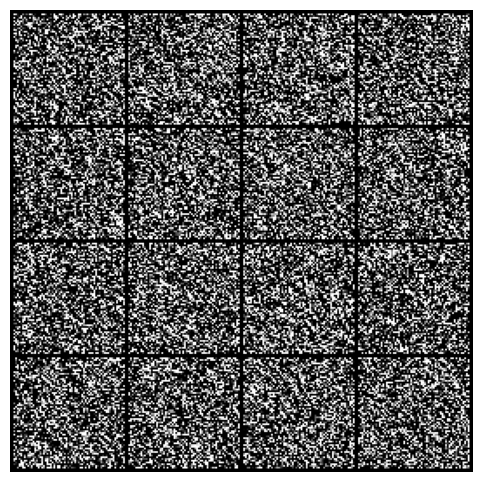

out torch.Size([128, 64, 64, 64])
out
out torch.Size([128, 64, 64, 64])
out
out
out torch.Size([128, 128, 32, 32])
out
out torch.Size([128, 128, 32, 32])
out
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
attention
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 128, 16, 16])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 64, 32, 32])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])


2025-05-23 08:39:10,520 - INFO - loss:0.6148831844329834


out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
attention
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 128, 16, 16])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 64, 32, 32])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
t tensor([90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90])
x_t torch.Size([16, 1, 64, 64])
sqrt_recipm1_alphas_cumprod torch.Size([100])
noise torch.Size([16, 1, 64, 64])
x_t shape torch.Size([16, 1, 64, 64])
out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out

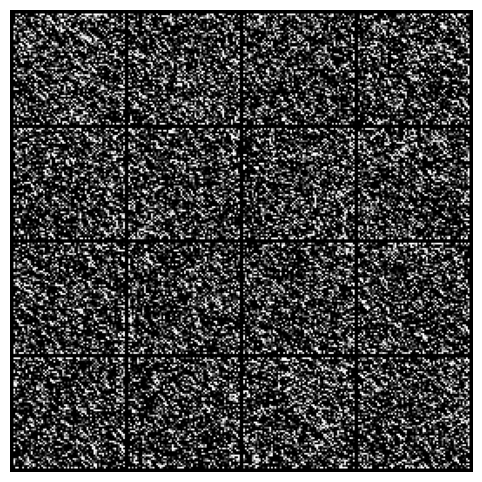

out torch.Size([128, 64, 64, 64])
out
out torch.Size([128, 64, 64, 64])
out
out
out torch.Size([128, 128, 32, 32])
out
out torch.Size([128, 128, 32, 32])
out
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
attention
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 128, 16, 16])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 64, 32, 32])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])


2025-05-23 08:48:21,917 - INFO - loss:0.45527416467666626


out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
attention
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 128, 16, 16])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 64, 32, 32])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
t tensor([90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90])
x_t torch.Size([16, 1, 64, 64])
sqrt_recipm1_alphas_cumprod torch.Size([100])
noise torch.Size([16, 1, 64, 64])
x_t shape torch.Size([16, 1, 64, 64])
out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out

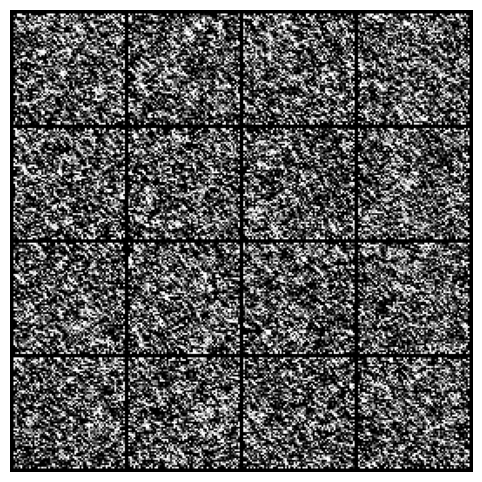

out torch.Size([128, 64, 64, 64])
out
out torch.Size([128, 64, 64, 64])
out
out
out torch.Size([128, 128, 32, 32])
out
out torch.Size([128, 128, 32, 32])
out
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
attention
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 128, 16, 16])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 64, 32, 32])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])


2025-05-23 08:57:15,917 - INFO - loss:0.3340938687324524


out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
attention
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 128, 16, 16])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 64, 32, 32])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
t tensor([90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90])
x_t torch.Size([16, 1, 64, 64])
sqrt_recipm1_alphas_cumprod torch.Size([100])
noise torch.Size([16, 1, 64, 64])
x_t shape torch.Size([16, 1, 64, 64])
out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out

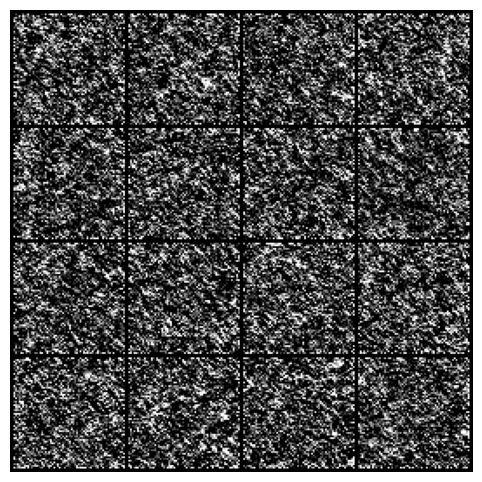

out torch.Size([128, 64, 64, 64])
out
out torch.Size([128, 64, 64, 64])
out
out
out torch.Size([128, 128, 32, 32])
out
out torch.Size([128, 128, 32, 32])
out
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
attention
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 128, 16, 16])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 64, 32, 32])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])


2025-05-23 09:06:12,315 - INFO - loss:0.22782854735851288


out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
attention
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 128, 16, 16])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 64, 32, 32])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
t tensor([90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90])
x_t torch.Size([16, 1, 64, 64])
sqrt_recipm1_alphas_cumprod torch.Size([100])
noise torch.Size([16, 1, 64, 64])
x_t shape torch.Size([16, 1, 64, 64])
out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out

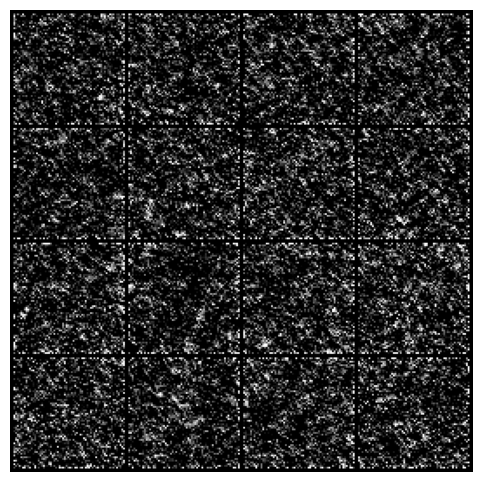

out torch.Size([128, 64, 64, 64])
out
out torch.Size([128, 64, 64, 64])
out
out
out torch.Size([128, 128, 32, 32])
out
out torch.Size([128, 128, 32, 32])
out
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
attention
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 128, 16, 16])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 64, 32, 32])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])


2025-05-23 09:15:16,621 - INFO - loss:0.2144397646188736


out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
attention
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 128, 16, 16])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 64, 32, 32])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
t tensor([90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90])
x_t torch.Size([16, 1, 64, 64])
sqrt_recipm1_alphas_cumprod torch.Size([100])
noise torch.Size([16, 1, 64, 64])
x_t shape torch.Size([16, 1, 64, 64])
out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out

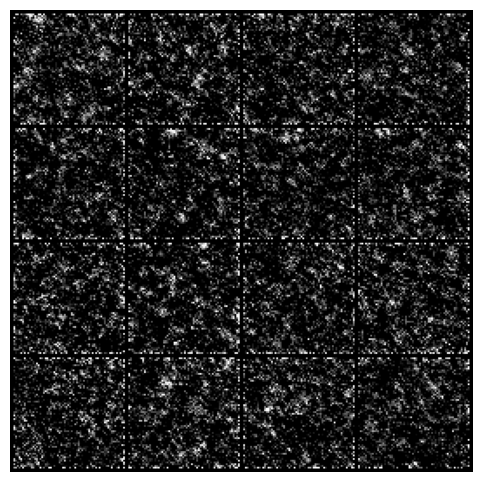

out torch.Size([128, 64, 64, 64])
out
out torch.Size([128, 64, 64, 64])
out
out
out torch.Size([128, 128, 32, 32])
out
out torch.Size([128, 128, 32, 32])
out
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
attention
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 128, 16, 16])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 64, 32, 32])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])


2025-05-23 09:24:17,221 - INFO - loss:0.19492289423942566


out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
attention
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 128, 16, 16])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 64, 32, 32])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
t tensor([90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90])
x_t torch.Size([16, 1, 64, 64])
sqrt_recipm1_alphas_cumprod torch.Size([100])
noise torch.Size([16, 1, 64, 64])
x_t shape torch.Size([16, 1, 64, 64])
out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out

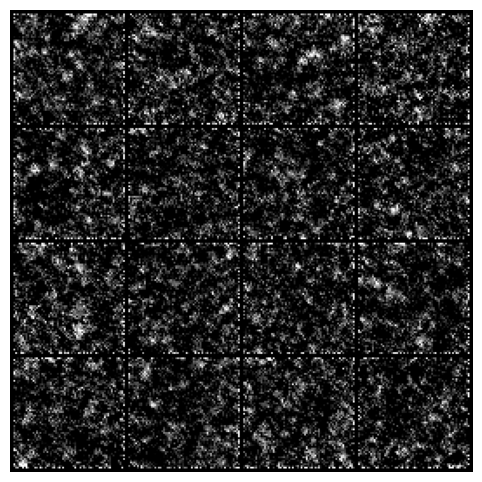

out torch.Size([128, 64, 64, 64])
out
out torch.Size([128, 64, 64, 64])
out
out
out torch.Size([128, 128, 32, 32])
out
out torch.Size([128, 128, 32, 32])
out
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
attention
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 128, 16, 16])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 64, 32, 32])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])


2025-05-23 09:33:16,718 - INFO - loss:0.16709619760513306


out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
attention
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 128, 16, 16])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 64, 32, 32])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
t tensor([90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90])
x_t torch.Size([16, 1, 64, 64])
sqrt_recipm1_alphas_cumprod torch.Size([100])
noise torch.Size([16, 1, 64, 64])
x_t shape torch.Size([16, 1, 64, 64])
out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out

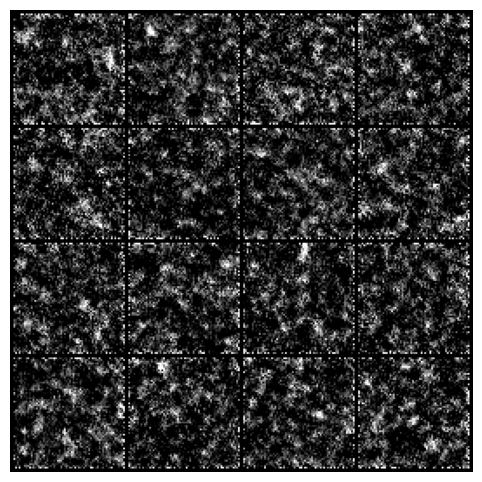

  0%|          | 0/8 [00:00<?, ?it/s]

out torch.Size([128, 64, 64, 64])
out
out torch.Size([128, 64, 64, 64])
out
out
out torch.Size([128, 128, 32, 32])
out
out torch.Size([128, 128, 32, 32])
out
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
attention
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 128, 16, 16])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 64, 32, 32])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])


2025-05-23 09:42:16,620 - INFO - loss:0.17478999495506287


out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
attention
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 128, 16, 16])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 64, 32, 32])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
t tensor([90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90])
x_t torch.Size([16, 1, 64, 64])
sqrt_recipm1_alphas_cumprod torch.Size([100])
noise torch.Size([16, 1, 64, 64])
x_t shape torch.Size([16, 1, 64, 64])
out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out

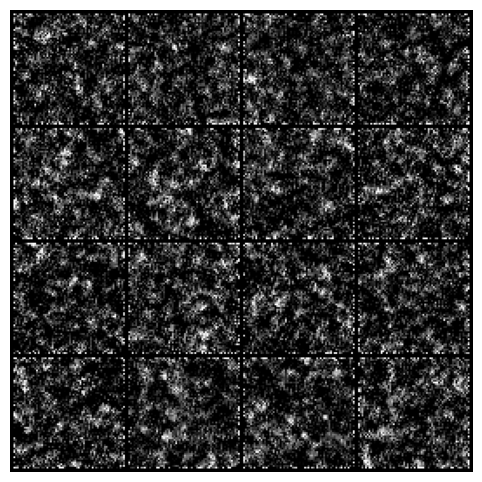

out torch.Size([128, 64, 64, 64])
out
out torch.Size([128, 64, 64, 64])
out
out
out torch.Size([128, 128, 32, 32])
out
out torch.Size([128, 128, 32, 32])
out
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
attention
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 128, 16, 16])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 64, 32, 32])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])


2025-05-23 09:51:14,719 - INFO - loss:0.19618643820285797


out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
attention
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 128, 16, 16])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 64, 32, 32])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
t tensor([90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90])
x_t torch.Size([16, 1, 64, 64])
sqrt_recipm1_alphas_cumprod torch.Size([100])
noise torch.Size([16, 1, 64, 64])
x_t shape torch.Size([16, 1, 64, 64])
out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out

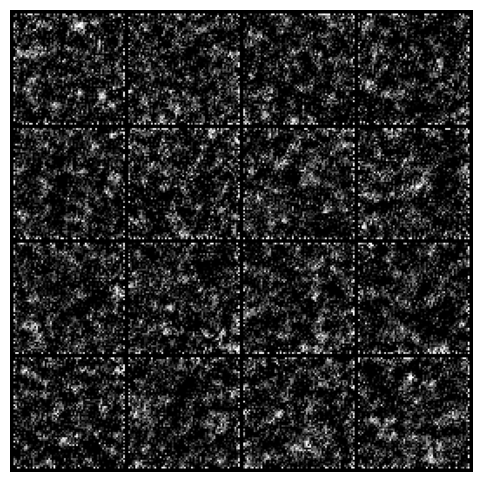

out torch.Size([128, 64, 64, 64])
out
out torch.Size([128, 64, 64, 64])
out
out
out torch.Size([128, 128, 32, 32])
out
out torch.Size([128, 128, 32, 32])
out
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
attention
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 128, 16, 16])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 64, 32, 32])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])


2025-05-23 10:00:10,118 - INFO - loss:0.15459370613098145


out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
attention
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 128, 16, 16])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 64, 32, 32])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
t tensor([90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90])
x_t torch.Size([16, 1, 64, 64])
sqrt_recipm1_alphas_cumprod torch.Size([100])
noise torch.Size([16, 1, 64, 64])
x_t shape torch.Size([16, 1, 64, 64])
out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out

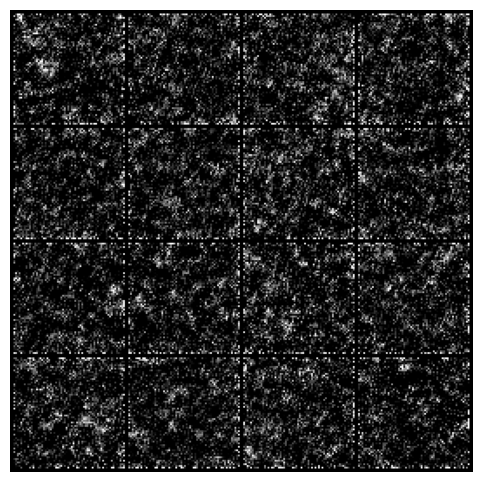

out torch.Size([128, 64, 64, 64])
out
out torch.Size([128, 64, 64, 64])
out
out
out torch.Size([128, 128, 32, 32])
out
out torch.Size([128, 128, 32, 32])
out
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
attention
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 128, 16, 16])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 64, 32, 32])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])


2025-05-23 10:09:11,221 - INFO - loss:0.14279334247112274


out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
attention
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 128, 16, 16])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 64, 32, 32])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
t tensor([90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90])
x_t torch.Size([16, 1, 64, 64])
sqrt_recipm1_alphas_cumprod torch.Size([100])
noise torch.Size([16, 1, 64, 64])
x_t shape torch.Size([16, 1, 64, 64])
out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out

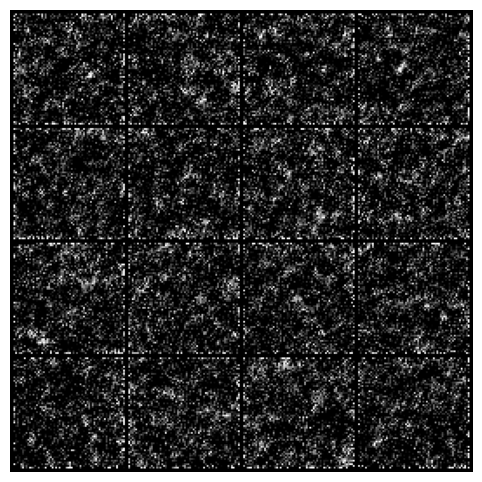

out torch.Size([128, 64, 64, 64])
out
out torch.Size([128, 64, 64, 64])
out
out
out torch.Size([128, 128, 32, 32])
out
out torch.Size([128, 128, 32, 32])
out
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
attention
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 128, 16, 16])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 64, 32, 32])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])


2025-05-23 10:18:11,717 - INFO - loss:0.15705205500125885


out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
out
out torch.Size([16, 256, 16, 16])
attention
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 256, 16, 16])
out torch.Size([16, 128, 16, 16])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 128, 32, 32])
out torch.Size([16, 64, 32, 32])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
out torch.Size([16, 64, 64, 64])
t tensor([90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90])
x_t torch.Size([16, 1, 64, 64])
sqrt_recipm1_alphas_cumprod torch.Size([100])
noise torch.Size([16, 1, 64, 64])
x_t shape torch.Size([16, 1, 64, 64])
out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])
out
out
out

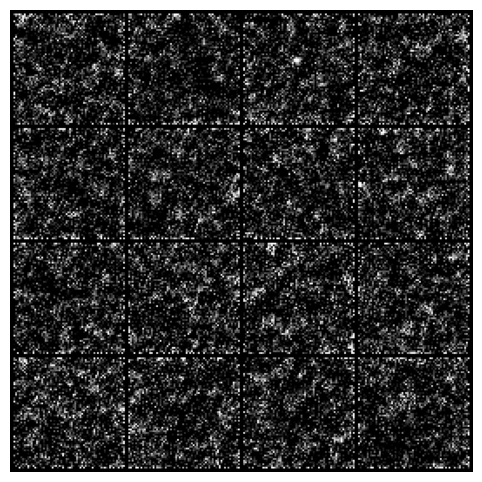

out torch.Size([128, 64, 64, 64])
out
out torch.Size([128, 64, 64, 64])
out
out
out torch.Size([128, 128, 32, 32])
out
out torch.Size([128, 128, 32, 32])
out
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
out
out torch.Size([128, 256, 16, 16])
attention
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 256, 16, 16])
out torch.Size([128, 128, 16, 16])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 128, 32, 32])
out torch.Size([128, 64, 32, 32])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])
out torch.Size([128, 64, 64, 64])


2025-05-23 10:27:00,616 - INFO - loss:0.14415356516838074


out torch.Size([16, 64, 64, 64])
out
out torch.Size([16, 64, 64, 64])
out
out
out torch.Size([16, 128, 32, 32])
out
out torch.Size([16, 128, 32, 32])


In [ ]:
from omegaconf import OmegaConf
conf=OmegaConf.load('/content/drive/MyDrive/SD.yaml')
img_path='/content/drive/MyDrive/filter/'
model=SDWrapper(conf.model.Encoder,conf.model.Decoder,conf.model.SD,img_path,16)
# model.train(torch.tensor([1]*16,dtype=torch.long),16,(16,4,64,64))
model.train(20,(16,1,64,64),10,0)